In [54]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../')))

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import decimal
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from util.db_util import DatabaseUtility

In [55]:
# Read .bashrc and update os.environ
bashrc_path = os.path.expanduser("~/.bashrc")
if os.path.exists(bashrc_path):
    with open(bashrc_path, "r") as f:
        for line in f:
            if line.startswith("export "):
                key_value = line.replace("export ", "").strip().split("=", 1)
                if len(key_value) == 2:
                    key, value = key_value
                    os.environ[key] = value.strip().strip("'").strip('"')

db_util = DatabaseUtility()

# Fetch training data
test_year = 2025
db_util.cursor.execute(f"""
    SELECT player_id, name, draft_cap, cupps_score, production_score, size_score, avg_fppg_nfl 
    FROM te_model_data
    WHERE draft_year NOT IN ({test_year}, 2025)
""")
rows = db_util.cursor.fetchall()
columns = [desc[0] for desc in db_util.cursor.description]
df_train = pd.DataFrame(rows, columns=columns)

# Fetch test data (test year WR prospects)
db_util.cursor.execute(f"""
    SELECT player_id, name, draft_cap, cupps_score, production_score, size_score, avg_fppg_nfl 
    FROM te_model_data
    WHERE draft_year = {test_year};
""")

rows_2025 = db_util.cursor.fetchall()
df_test = pd.DataFrame(rows_2025, columns=columns)
db_util.conn.close()

# Store identifiers for later merging
df_test_identifiers = df_test[["player_id", "name"]].copy()

In [56]:
null_columns = df_train.columns[df_train.isnull().any()]

print("\nSummary of columns with nulls:")
for col in null_columns:
    null_count = df_train[col].isnull().sum()
    avg_value = df_train[col].mean()
    print(f"{col}: {null_count} missing | Avg (ignoring nulls): {avg_value:.2f}")

# Convert numeric columns to float, including any decimal.Decimal values
for df in [df_train, df_test]:
    for col in df.columns:
        if df[col].apply(lambda x: isinstance(x, (int, float, np.number, decimal.Decimal))).any():
            df[col] = df[col].astype(float)

df_train_numeric_cols = df_train.select_dtypes(include=[np.number]).columns
df_test_numeric_cols = df_test.select_dtypes(include=[np.number]).columns
# Any player that did not ever hit 10 games in a season will have a NULL value for average NFL FPPG.
# I am deciding to assign them a value of 0 to indicate the level of which they busted, rather than the average of the rest of our dataset.
df_train["avg_fppg_nfl"] = df_train["avg_fppg_nfl"].fillna(0)
df_train[df_train_numeric_cols] = df_train[df_train_numeric_cols].fillna(df_train[df_train_numeric_cols].mean())
df_test[df_test_numeric_cols] = df_test[df_test_numeric_cols].fillna(df_test[df_test_numeric_cols].mean())


Summary of columns with nulls:


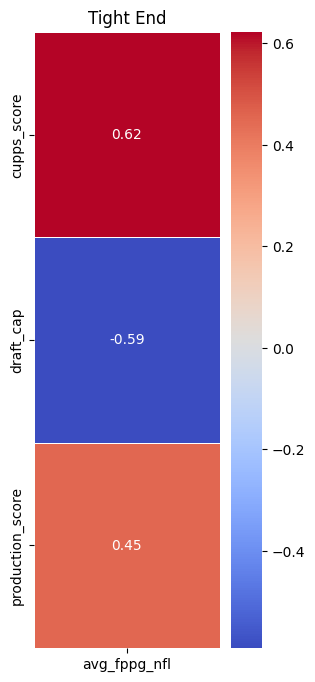

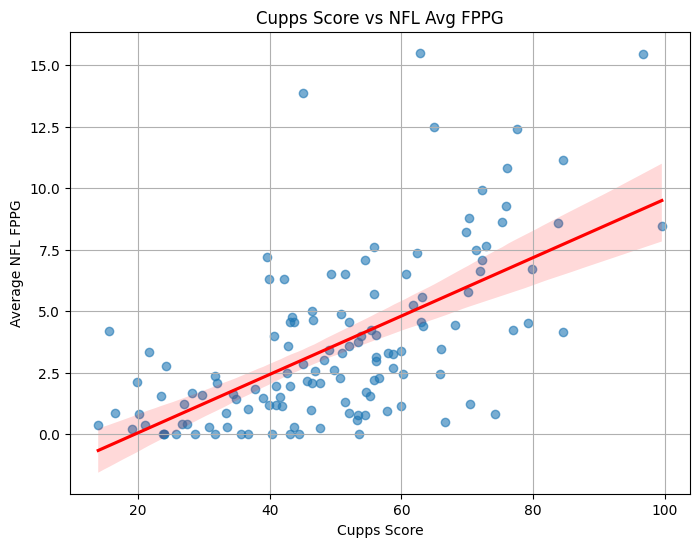

In [69]:
# Compute correlation matrix
correlation_matrix = df_train[df_train_numeric_cols].corr()

# Get correlations with avg_fppg_nfl and sort them (using abs since DC is inversely correlated)
correlations = correlation_matrix["avg_fppg_nfl"].dropna().abs().sort_values(ascending=False)

# Select the top N correlated features (excluding avg_fppg_nfl itself)
top_corr_features = correlations.index[1:4]  # Get top 10 correlated features

# Extract the correlation matrix for the selected features
top_corr_matrix = correlation_matrix.loc[top_corr_features, ["avg_fppg_nfl"]]

# Plot the heatmap
plt.figure(figsize=(3, 8))
sns.heatmap(top_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Tight End")
plt.show()

# --- Scatter plot of cupps_score vs avg_fppg_nfl ---
plt.figure(figsize=(8, 6))
sns.regplot(
    data=df_train,
    x="cupps_score",
    y="avg_fppg_nfl",
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'red'}
    )
plt.title("Cupps Score vs NFL Avg FPPG")
plt.xlabel("Cupps Score")
plt.ylabel("Average NFL FPPG")
plt.grid(True)
plt.show()

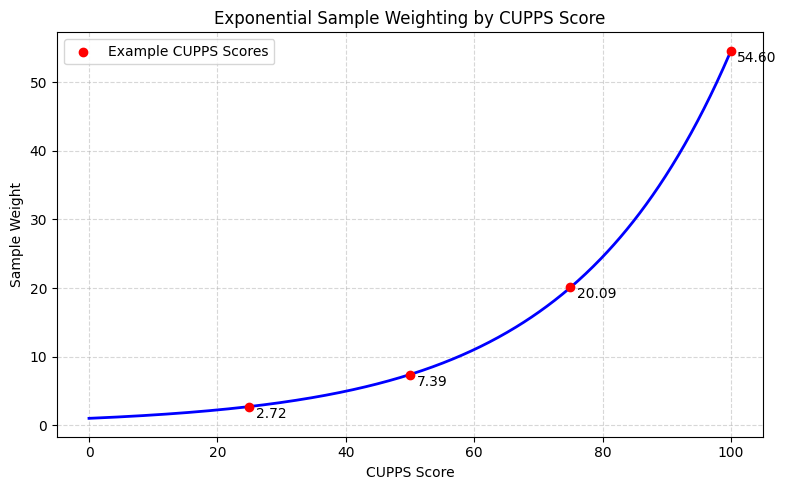

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a range of CUPPS scores
cupps_scores = np.linspace(0, 100, 500)
sample_weights = np.exp(cupps_scores / 25)

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(cupps_scores, sample_weights, color='blue', linewidth=2)
plt.scatter([25, 50, 75, 100],
            [np.exp(25/25), np.exp(50/25), np.exp(75/25), np.exp(100/25)],
            color='red', zorder=5, label='Example CUPPS Scores')
for score in [25, 50, 75, 100]:
    weight = np.exp(score/25)
    plt.text(score + 1, weight, f"{weight:.2f}", fontsize=10, va='top')

plt.xlabel("CUPPS Score")
plt.ylabel("Sample Weight")
plt.title("Exponential Sample Weighting by CUPPS Score")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()



📈 Sorted TE Predictions (2025 Prospects):
 player_id              name  CUPPS Score  Production Score  Draft Pick  Predicted FPPG  Actual FPPG  Residual
     18112  Colston Loveland        90.17             75.84        10.0           16.05          0.0    -16.05
     17166      Tyler Warren        87.81             69.57        14.0           15.72          0.0    -15.72
     18382 Harold Fannin Jr.        83.64             96.97        67.0           10.20          0.0    -10.20
     18140      Mason Taylor        70.55             46.79        42.0            6.43          0.0     -6.43
     17178 Terrance Ferguson        69.50             46.14        46.0            6.24          0.0     -6.24
     17366     Elijah Arroyo        62.48             35.65        50.0            5.27          0.0     -5.27
     17088 Oronde Gadsden II        58.73             79.88       165.0            3.76          0.0     -3.76
     17222    Mitchell Evans        49.70             56.13       163

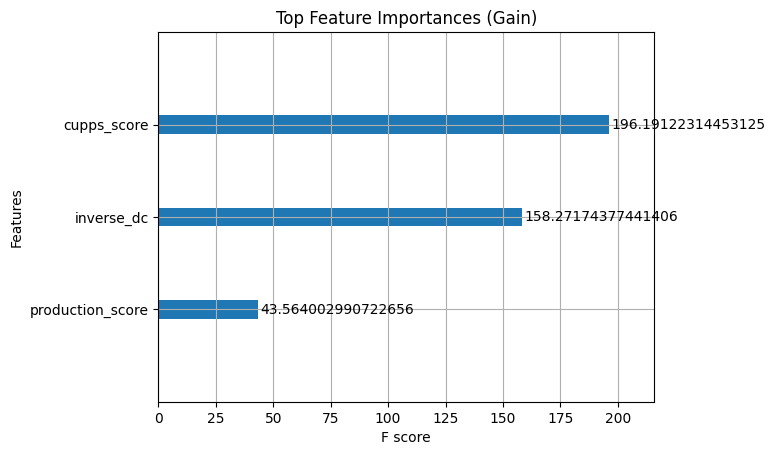

In [81]:
# Define input/output
y_train = df_train["avg_fppg_nfl"]
y_test_actual = df_test["avg_fppg_nfl"]

X_train = df_train.copy()
X_test = df_test.copy()

#Add a nonlinear version of draft capital
X_train["inverse_dc"] = 1 / (X_train["draft_cap"].fillna(300) + 1)
X_test["inverse_dc"] = 1 / (X_test["draft_cap"].fillna(300) + 1)

#Exponentially weight samples with higher CUPPS scores
sample_weights = np.exp(X_train["cupps_score"] / 25)
#Only include three features in the model training to avoid noise
final_features = ["cupps_score", "production_score", "inverse_dc"]
#Monotone constraints allows us to tell our model that we believe these three features should generally be positively correlated with the prediction values
monotone_constraints = "(1,1,1)"

xgb_simple = xgb.XGBRegressor(
    max_depth=6, n_estimators=300, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.7,
    objective="reg:squarederror",
    monotone_constraints = monotone_constraints,    
    random_state=42
)

#Remove the features we don't want to feed the model, only feed it our final features
X_train = X_train[final_features]
X_test = X_test[final_features]
xgb_simple.fit(X_train, y_train, sample_weight=sample_weights)

#Predict on test set
y_pred = xgb_simple.predict(X_test)

#This function allows us to exponentially boost the FPPG predictions of elite prospects
#Max boost = 5 extra FPPG
#Center = 80 - the CUPPS score at which the boost hits 50%
#CUPPS 80: boost ≈ 2.5 FPPG
#CUPPS <80: less than 2.5
#CUPPS >80: more than 2.5, approaching 5 as it nears 95+
def stretch_elite_predictions(preds, cupps):
    max_boost = 5
    steepness = 0.25
    center = 80
    boost = max_boost / (1 + np.exp(-steepness * (cupps - center)))
    return preds + boost

y_pred = stretch_elite_predictions(y_pred, X_test["cupps_score"])

# Create residuals DataFrame
df_results = pd.DataFrame({
    "Actual FPPG": y_test_actual.values,
    "Predicted FPPG": y_pred,
    "Residual (Actual - Predicted)": y_test_actual.values - y_pred
})

# Merge predictions, actuals, and residuals
df_predictions = df_test_identifiers.copy()
df_predictions["CUPPS Score"] = X_test["cupps_score"].round(2)
df_predictions["Production Score"] = X_test["production_score"].round(2)
df_predictions["Draft Pick"] = df_test["draft_cap"].values
df_predictions["Predicted FPPG"] = y_pred.round(2)
df_predictions["Actual FPPG"] = y_test_actual.where(pd.notnull(y_test_actual)).round(2)
df_predictions["Residual"] = df_predictions["Actual FPPG"] - df_predictions["Predicted FPPG"].round(2)

# Sort by predicted FPPG
df_predictions = df_predictions.sort_values(by="Predicted FPPG", ascending=False).reset_index(drop=True)

# Display
print(f"\n📈 Sorted TE Predictions ({test_year} Prospects):")
print(df_predictions.to_string(index=False))

xgb.plot_importance(xgb_simple, importance_type='gain', max_num_features=10)
plt.title("Top Feature Importances (Gain)")
plt.show()

| Metric                   | Correlation Matrix (`.corr()`)            | XGBoost Gain Importance                                 |
| ------------------------ | ----------------------------------------- | ------------------------------------------------------- |
| **Type of Relationship** | Linear only                               | Captures nonlinear, hierarchical splits                 |
| **Context**              | Global — compares entire column to target | Local — evaluates each tree's split decision            |
| **Interaction Effects**  | Not captured                              | Captures feature interactions via tree structure        |
| **Output Value**         | Ranges -1 to 1                            | Arbitrary (based on cumulative gain across tree splits) |
| **Sensitivity**          | Sensitive to outliers and collinearity    | Sensitive to how features guide splits and improve fit  |
| **Interpretability**     | More intuitive but simplistic             | More nuanced, but harder to intuit directly             |


In [78]:
print(f"Sorted TE Predictions ({test_year} Prospects):")
print("-" * 85)
print(f"{'name':<25} {'CUPPS':>6} {'Predicted':>10}")
print(f"{'':<25} {'Score':>6} {'FPPG':>10}")
print("-" * 85)

for _, row in df_predictions.iterrows():
    print(f"{row['name'][:24]:<25} "
          f"{row['CUPPS Score']:6.2f} {row['Predicted FPPG']:10.2f}")

print("-" * 85)


Sorted TE Predictions (2025 Prospects):
-------------------------------------------------------------------------------------
name                       CUPPS  Predicted
                           Score       FPPG
-------------------------------------------------------------------------------------
Colston Loveland           90.17      16.05
Tyler Warren               87.81      15.72
Harold Fannin Jr.          83.64      10.20
Mason Taylor               70.55       6.43
Terrance Ferguson          69.50       6.24
Elijah Arroyo              62.48       5.27
Oronde Gadsden II          58.73       3.76
Mitchell Evans             49.70       3.20
Gunnar Helm                46.76       2.81
Robbie Ouzts               29.05       0.64
Jackson Hawes              31.48       0.64
Gavin Bartholomew          31.22       0.47
Moliki Matavao             27.66       0.38
Luke Lachey                30.96      -0.72
------------------------------------------------------------------------------------

In [107]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd

X = df_train[["cupps_score", "production_score"]].copy()
X["inverse_dc"] = 1 / (df_train["draft_cap"].fillna(300))
y = df_train["avg_fppg_nfl"]

# --- Step 1: Bin the target ---
# You can adjust the number of bins based on your dataset size
n_bins = 5
y_binned = pd.qcut(y, q=n_bins, labels=False, duplicates="drop")

# --- Step 2: StratifiedKFold using binned labels ---
skf = StratifiedKFold(n_splits=25, shuffle=True, random_state=5)

r2_scores = []

for train_idx, val_idx in skf.split(X, y_binned):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    weights_train = np.exp(X_train_fold["cupps_score"] / 100)
    
    xgb_simple.fit(X_train_fold, y_train_fold, sample_weight=weights_train)
    y_pred = xgb_simple.predict(X_val_fold)

    r2 = r2_score(y_val_fold, y_pred)
    r2_scores.append(r2)

print(f"📊 Stratified Cross-validated R² scores: {r2_scores}")
print(f"✅ Average R²: {np.mean(r2_scores):.3f}")


📊 Stratified Cross-validated R² scores: [0.5969613230391504, 0.44139038742535086, 0.46694033897117637, 0.3929082123651094, -1.0305840520444218, -0.640644407693387, 0.5732177041240716, 0.5332623191845174, 0.39203550115517716, -0.27875497023171514, 0.13926957358882253, 0.6225662666278169, 0.6835553761551985, 0.7620874209799817, 0.38434185330655046, -0.3999001863300937, 0.6029360557212957, 0.9723431907906763, -0.16537388056026736, 0.27335505003179084, 0.6729655662766957, -0.11874856067309558, 0.6884882513495387, 0.7259803281836309, -0.19432611192636906]
✅ Average R²: 0.284
